<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part II in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [1]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Solution to ODE Initial Value Problems - Part 1

Many physical, biological, and societal systems can be written as a system of ordinary differential equations (ODEs).  In the case where the initial state (value) is know the problems can be written as

$$
    \frac{\text{d}\mathbf{u}}{\text{d}t} = \mathbf{f}(t, \mathbf{u}) \quad \mathbf{u}(0) = \mathbf{u}_0
$$

where
 - $\mathbf{\!u}(t)$ is the state vector (e.g. population)
 - $\mathbf{\!f}(t, \mathbf{\!u})$ is a vector-valued function that controls the growth of $\mathbf{u}$ with time
 - $\mathbf{\!u}(0)$ is the initial condition at time $t = 0$

#### Examples:  Simple radioactive decay
$$
    \mathbf{\!u} = [c]
$$
   
$$
    \frac{\text{d} c}{\text{d}t} = \lambda c \quad c(0) = c_0
$$
   

which has solutions of the form $c(t) = c_0 e^{\lambda t}$

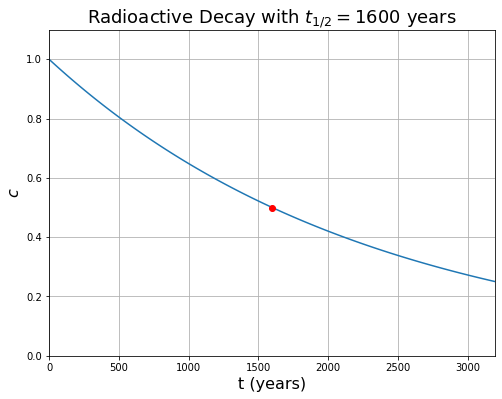

In [2]:
t = numpy.linspace(0.0, 3200., 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, 1.0 * numpy.exp(decay_constant * t))
axes.plot(1600.,0.5,'ro')
axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('$c$', fontsize=16)
axes.set_xlim((0.0, t[-1]))
axes.set_ylim((0.0, 1.1))
axes.grid()
plt.show()

#### Examples:  Complex radioactive decay (or chemical system).

Chain of decays (coupled decay) from one species to another.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_3}{\text{d}t} &= \lambda_2 c_3 - \lambda_3 c_3 
\end{aligned}$$

$$\frac{\text{d} \mathbf{u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} = 
\begin{bmatrix} 
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \mathbf{u}}{\text{d}t} = A \mathbf{u}$$

For systems of equations like this the general solution to the ODE is the matrix exponential:

$$\mathbf{u}(t) = \mathbf{u}_0 e^{A t}$$

Note: A is lower triangular; eigenvalue of A

#### Examples:  Particle tracking in a fluid

$$\frac{\text{d} \mathbf{X}}{\text{d}t} = \mathbf{V}(t, \mathbf{X})$$

In fact all ODE IVP systems can be thought of as tracking particles through a flow field (dynamical system).  In 1-dimension the flow "manifold" we are on is fixed by the initial condition.

#### Examples: Van der Pol Oscillator

$$y'' - \mu (1 - y^2) y' + y = 0 \quad \quad \text{with} \quad \quad  y(0) = y_0, \quad y'(0) = v_0$$
 

$$\mathbf{u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \mathbf{f}(t, \mathbf{u})$$

In [5]:
from scipy.integrate import solve_ivp

def f_vanderpol(t, u, mu=5):
    """
    u is vector of y and y'
    """
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

# N = 100
N = 500
t_span = (0., 200.)
u0 = [ 1., 0. ]
f = lambda t, u : f_vanderpol(t, u, mu=50)
sol = solve_ivp(f, t_span, u0, method='BDF')

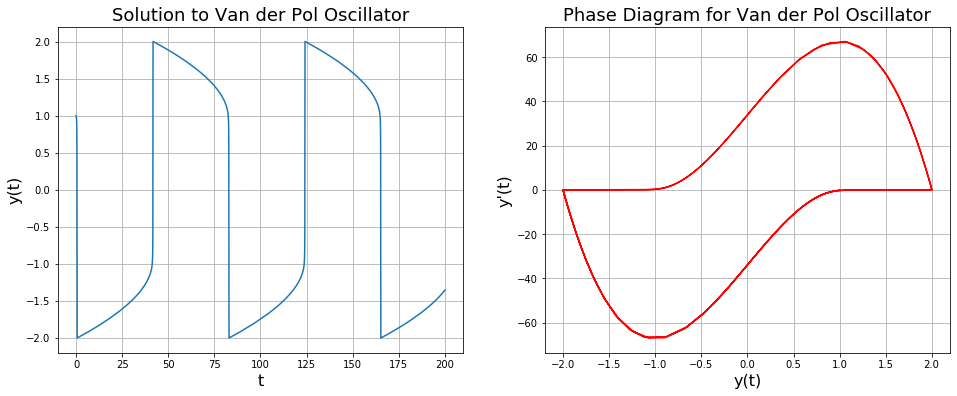

In [6]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)

axes.plot(sol.t, sol.y[0])
axes.set_title("Solution to Van der Pol Oscillator", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("y(t)", fontsize=16)
axes.grid()

axes = fig.add_subplot(1, 2, 2)

axes.plot(sol.y[0],sol.y[1],'r')
axes.set_title("Phase Diagram for Van der Pol Oscillator", fontsize=18)
axes.set_xlabel("y(t)", fontsize=16)
axes.set_ylabel("y'(t)", fontsize=16)
axes.grid()
plt.show()

## Basic Stepping Schemes

Introducing some notation to simplify things
$$\begin{aligned}
    t_0 &= 0 \\
    t_1 &= t_0 + \Delta t \\
    t_n &= t_{n-1} + \Delta t = n \Delta t + t_0 \\
    u_0 &= u(t_0) \approx U_0 \mbox{ (continuous) }\\
    u_1 &= u(t_1) \approx U_1 \mbox{ (discrete) }\\
    u_n &= u(t_n) \approx U_2 \mbox{ (discrete) }\\
\end{aligned}$$
where lower-case letters are "exact".  

Looking back at our work on numerical differentiation why not approximate the derivative as a finite difference:

$$
    \frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)
$$

__We still need to decide how to evaluate the $f(t, u)$ term however.__  

#### Relationship to quadrature

Actually it is often more instructive to work with the integral form of an ODE

$$
    \int^{t + \Delta t}_t \frac{\text{d} u}{\text{d}\tilde{\!t}} d\tilde{\!t} = \int^{t + \Delta t}_t f(t, u) d\tilde{\!t}
$$

which is equivalent to the differential form.  However using the fundamental theorem of calculus tells us that the LHS is $u(t + \Delta t) - u(t)$  so we can write the ODE as

$$ 
    u(t + \Delta t) = u(t) + \int^{t + \Delta t}_t f(t, u) d\tilde{\!t}
$$

Note: use quadrature to evaluate integral!


#### The Geometric picture

$$
    \frac{\text{d} u}{\text{d} t} = f(t,u)
$$
says $f$ is a slope field that is tangent to any solution $u(t)$ that passes through $u_0$ at $t=t_0$

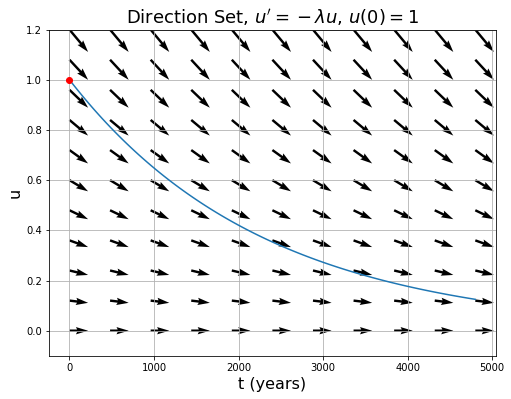

In [7]:
t = numpy.linspace(0., 4800, 11)
y = numpy.linspace(0., 1.2, 11)
T, Y = numpy.meshgrid(t,y)
dt = numpy.ones(T.shape)
dy = -dt*Y

tp = numpy.linspace(0., 4800, 100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(T,Y, dt,dy)
axes.plot(tp,numpy.exp(decay_constant*tp))
axes.plot(0.,1.,'ro')
axes.grid()
axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('u', fontsize=16)

axes.set_ylim((-.1,1.2))
plt.show()



Alternatively 

$$ 
    u(t + \Delta t) = u(t) + \int^{t + \Delta t}_t f(\tilde{t}, u(\tilde{t})) d\tilde{\!t}
$$
Implies, that $u$ at some time $\Delta t$ in the future,  is $u(t)$ plus a *number* 
$$
    K = \int^{t + \Delta t}_t f(\tilde{t}, u(\tilde{t})) d\tilde{\!t}
$$
which is a definite *line integral* (along an unknown solution).  As we will see many of the algorithms for integrating ODE's can be related to simple quadrature rules for approximating $K$

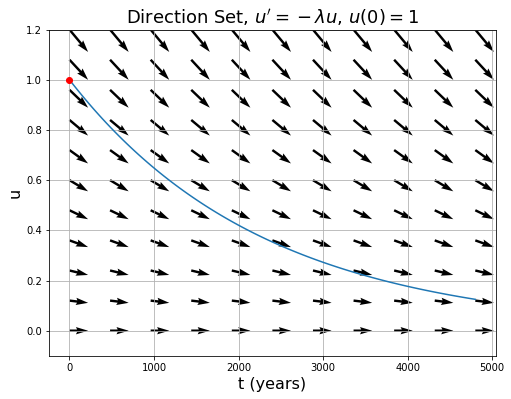

In [8]:
t = numpy.linspace(0., 4800, 11)
y = numpy.linspace(0., 1.2, 11)
T, Y = numpy.meshgrid(t,y)
dt = numpy.ones(T.shape)
dy = -dt*Y

tp = numpy.linspace(0., 4800, 100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(T,Y, dt,dy)
axes.plot(tp,numpy.exp(decay_constant*tp))
axes.plot(0.,1.,'ro')
axes.grid()
axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('u', fontsize=16)

axes.set_ylim((-.1,1.2))
plt.show()



For example, if we approximate $K$ with a left-sided quadrature rule
$$
    K = \int^{t + \Delta t}_t f(\tilde{t}, u(\tilde{t}) d\tilde{\!t} \approx \Delta t f(t, u(t))
$$

then our first ODE algorithm can be written
$$
u(t + \Delta t) =  u(t) + \Delta t f(t, u(t))
$$


or in terms of our discrete approximation $U$
$$
    U_{n+1} = U_n + \Delta t f(t_n, U_n)
$$

which is known as the __*forward Euler method*__.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

Note: not great algorithm! Literally just project line using left $f(t_n, U_n)$ point/slope.

In [9]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

# Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0)

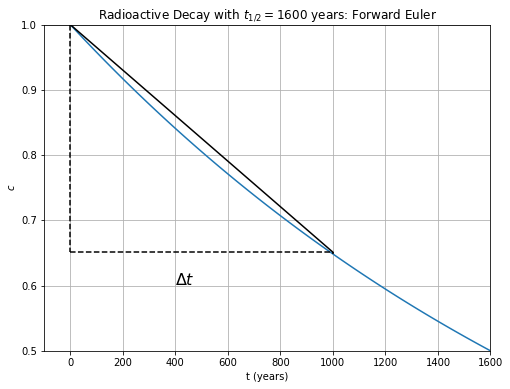

In [17]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years: Forward Euler")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
axes.grid()
plt.show()

In [13]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# Implement Forward Euler
t_euler = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t_euler[1] - t_euler[0]
u_euler = numpy.empty(t_euler.shape)
u_euler[0] = c_0
for (n, t_n) in enumerate(t_euler[:-1]):
    u_euler[n + 1] = u_euler[n] + delta_t * f(t_n, u_euler[n])

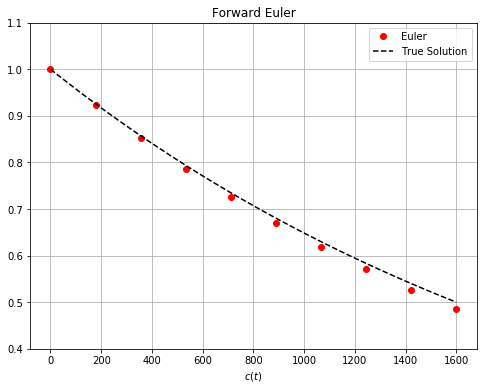

In [14]:
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_euler, u_euler, 'or', label="Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.grid()
axes.legend()
plt.show()

As $\Delta t \rightarrow 0$, error $\rightarrow 0$ with order $\Delta t$.

A similar method can be derived if we consider instead using the second order accurate *central difference*:

$$\frac{U_{n+1} - U_{n-1}}{2\Delta t} = f(t_{n}, U_{n})$$

this method is known as the __leap-frog method__.  Note that the way we have written this method requires a previous function evaluation and technically is a __"multi-step" method__ although we do not actually use the current evaluation.

Error is of order $(\Delta t)^2$.

Can initiate with Euler step (since don't have $U_{n-1}$)

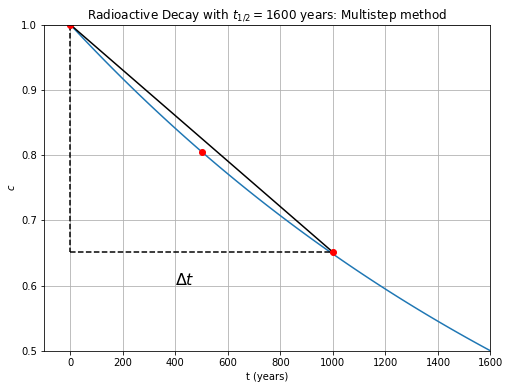

In [16]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")

# Plot Leap-Frog step
dt = 1e3
u1 = c_0 * numpy.exp(decay_constant * dt / 2.0)
u_np = c_0 + dt * (decay_constant * u1)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)
axes.plot([0., dt/2, dt], [ c_0, u1, u_np],'ro')
axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years: Multistep method")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.grid()
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

In [18]:
c_0 = 1.0
N = 25

# Stable example
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
t_leapfrog = numpy.linspace(0.0, 1.6e3, 5)

In [19]:
# Unstable example
# decay_constant = -1.0
# t_exact = numpy.linspace(0.0, 5.0, 100)
# t_leapfrog = numpy.linspace(0.0, 5.0, N)

f = lambda t, u: decay_constant * u


u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement leap-frog with initial Euler step
delta_t = t_leapfrog[1] - t_leapfrog[0]
u_leapfrog = numpy.empty(t_leapfrog.shape)
u_leapfrog[0] = c_0
u_leapfrog[1] = u_leapfrog[0] + delta_t * f(t_leapfrog[0], u_leapfrog[0])
# start with exact u[1]
#u_leapfrog[1] = u_leapfrog[0] * numpy.exp(decay_constant*delta_t)
for n in range(1, t_leapfrog.shape[0] - 1):
    u_leapfrog[n + 1] = u_leapfrog[n - 1] + 2.0 * delta_t * f(t_leapfrog[n], u_leapfrog[n])

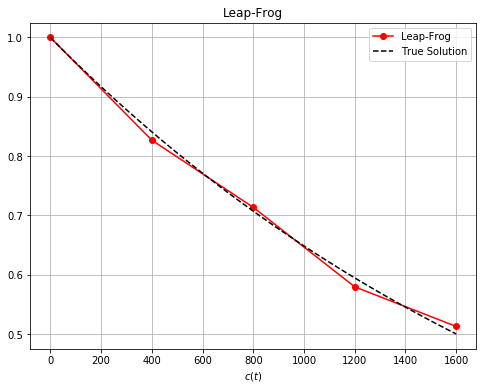

In [20]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_leapfrog, u_leapfrog, 'or-', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")
axes.grid()
axes.set_title("Leap-Frog")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.legend()
plt.show()

Note: Since started with Euler method, first leap frog point is not exact, thus introducing error.

Similar to forward Euler is the __*backward Euler* method__ which, as you may have guessed, evaluates the function $f$ at the updated time so that

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

Schemes where the function $f$ is evaluated at the unknown time are called *implicit methods*.

For some cases we can solve the equation by hand.  For instance in the case of our example problem we have:

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}) = U_n + \Delta t (\lambda U_{n+1})
$$

which can be solved for $U_{n+1}$ to find

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (\lambda U_{n+1}) \\
    U_{n+1} \left[ 1 - \Delta t \lambda \right ] &= U_n \\
    U_{n+1} &= \frac{U_n}{1 - \Delta t \lambda} \leftarrow \mbox { stable, but large error } 
\end{aligned}$$

Note: for Forward Euler - 
$$
U_{n+1} = U_n + \Delta t (\lambda U_n) \leftarrow \mbox{ large $\Delta t$ will blow up }
$$

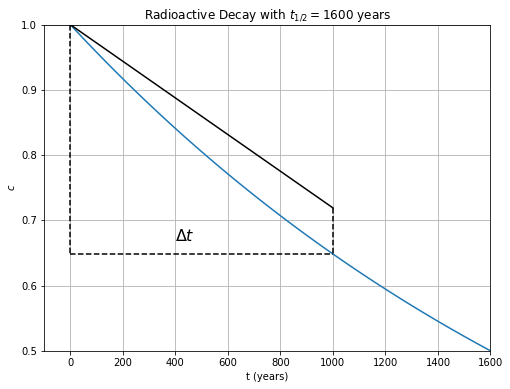

In [21]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")

# Plot Backwards Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0 * numpy.exp(decay_constant * dt))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, dt), (c_0 * numpy.exp(decay_constant * dt), c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)
axes.grid()
axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

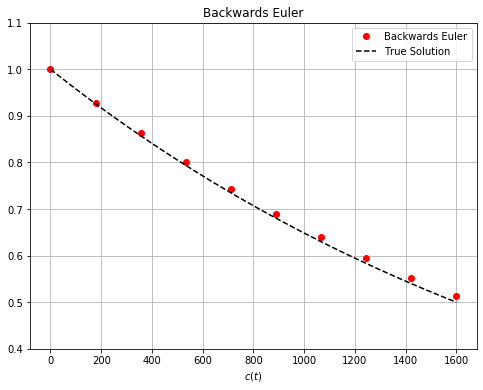

In [22]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement backwards Euler
t_backwards = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t_backwards[1] - t_backwards[0]
u_backwards = numpy.empty(t_backwards.shape)
u_backwards[0] = c_0
for n in range(0, t_backwards.shape[0] - 1):
    u_backwards[n + 1] = u_backwards[n] / (1.0 - decay_constant * delta_t)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_backwards, u_backwards, 'or', label="Backwards Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")
axes.grid()
axes.set_title("Backwards Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

Forward Euler on vector-valued system

It's also useful to be able to do this in the case of systems of ODEs.  Let $f(U) = A U$, then

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (A U_{n+1}) \\
    \left [ I - \Delta t A \right ] U_{n+1}  &= U_n \\
    U_{n+1} &= \left [ I - \Delta t A \right]^{-1} U_n
\end{aligned}$$

In general however we are often not able to do this with arbitrary $f$.

Note: inversion is actually an eigen solve (not actual inversion)

Another simple implicit method is based on quadrature using the trapezoidal method.  The scheme is
$$
    \frac{U_{n+1} - U_{n}}{\Delta t} = \frac{1}{2} (f(U_n) + f(U_{n+1}))
$$

In this case what is the update scheme if $f = \lambda U$?

$$\begin{aligned}
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (\lambda U_n + \lambda U_{n+1}) \\
    U_{n+1} \left[1 - \frac{\Delta t \lambda}{2}  \right] &= U_{n} \left[1 + \frac{\Delta t \lambda}{2} \right] \\
    U_{n+1} &= U_{n} \frac{1 + \frac{\Delta t \lambda}{2}}{1 - \frac{\Delta t \lambda}{2}} \\
\end{aligned}$$

More accurate than backward Euler, and stable.

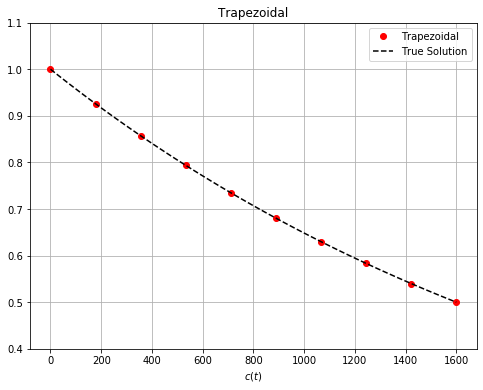

In [23]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement trapezoidal method
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
u = numpy.empty(t.shape)
u[0] = c_0
integration_constant = (1.0 + decay_constant * delta_t / 2.0) / (1.0 - decay_constant * delta_t / 2.0)
for n in range(t.shape[0] - 1):
    u[n + 1] = u[n] * integration_constant

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, u, 'or', label="Trapezoidal")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")
axes.grid()

axes.set_title("Trapezoidal")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

## Error Analysis of ODE Methods

At this point it is also helpful to introduce more notation to distinguish between the true solution to the ODE $u(t_n)$ and the approximated value which we will denote $U_n$.

**Definition:** We define the *truncation error* of a scheme by replacing the $U_n$ with the true solution $u(t_n)$ in the finite difference formula and looking at the difference from the exact solution.

For example we will use the difference form of forward Euler
$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n)
$$
and define the truncation error as
$$
    T(t, u; \Delta t) = \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n, u(t_n)).
$$

**Definition:** A method is called __*consistent*__ if 
$$
    \lim_{\Delta t \rightarrow 0} T(t, u; \Delta t) = 0.
$$

**Definition:** We say that a method is __*order $p$ accurate*__ if

$$
    \lVert T(t, u; \Delta t) \rVert \leq C \Delta t^p
$$

uniformally on $t \in [0, T]$.  This can also be written as $T(t, u; \Delta t) = \mathcal{O}(\Delta t^p)$.  Note that a method is consistent if $p > 0$ and $\Delta t \rightarrow 0$.

### Error Analysis of Forward Euler

We can analyze the error and convergence order of forward Euler by considering the Taylor series centered at $t_n$:

$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)
$$

Evaluating this series at $t_{n+1}$ gives

$$\begin{aligned}
    u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
    &=u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$$

From the definition of truncation error we can use our Taylor series expression and find the truncation error.  Take the finite difference form of forward Euler

$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n)
$$

and replacing the derivative formulation with $u(t_n)$ to find

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n) \\
    &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - u'(t_n).
\end{aligned}$$

From here we use the Taylor series centered at $t_n$ and evaluated at $t_{n+1}$ to find

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - u'(t_n) \\
    &= \frac{1}{\Delta t} \left[ (u(t_n) + u'(t_n) (t - t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)) - u(t_n) \right] - u'(t_n) \\
    &=  u'(t_n) + \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2) - u'(t_n) \\
    &= \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2).
\end{aligned}$$

This implies that forward Euler is first order accurate and therefore consistent, but error drops slowly.

Another equivalent definition of the truncation error uses the form
$$
    U_{n+1} = u(t_n) + \Delta t f(t_n)
$$
and the definition
$$
    T(t, u; \Delta t) = \frac{1}{\Delta t} \left [ U_{n+1} - u(t_{n+1}) \right]
$$

Step error $U_{n+1} - u(t_{n+1})$ is one order higher than $\Delta t$ or truncation error.

to find
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)] \\
    &= \frac{1}{\Delta t} \left[ \underbrace{u_n + \Delta t f(t_n, u_n)}_{U_{n+1}} - \underbrace{\left( u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right )}_{u(t_{n+1})}\right ] \\
    &= \frac{1}{\Delta t} \left[ - \frac{u''(t_n)}{2} \Delta t^2 - \mathcal{O}(\Delta t^3) \right ] \\
    &= - \frac{u''(t_n)}{2} \Delta t - \mathcal{O}(\Delta t^2)
\end{aligned}$$

### Error Analysis of Leap-Frog Method

To easily analyze this method we will expand the Taylor series from before to another order:
$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + (t - t_n)^2 \frac{u''(t_n)}{2}  + (t - t_n)^3 \frac{u'''(t_n)}{6} + \mathcal{O}((t-t_n)^4)
$$
leading to 
$$\begin{aligned}
    u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

We need one more expansion however due to leap-frog.  Recall that leap-frog has the form
$$
    \frac{U_{n+1} - U_{n-1}}{2 \Delta t} = f(t_n, U_n)
$$
or
$$
    U_{n+1} = U_{n-1} + 2 \Delta t f(t_n, U_n).
$$
To handle the $U_{n-1}$ term we need to write this with relation to $u(t_n)$.  Again we use the Taylor series
$$
    u(t_{n-1}) = u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
$$

$$\begin{aligned}
    u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
    u(t_{n-1}) &= u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

Plugging these into our definition of the truncation error along with the leap-frog method definition leads to

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\underbrace{U_{n-1} + 2 \Delta t f_n}_{U_{n+1}} - \underbrace{\left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )}_{u(t + \Delta t)} \right ] \\
    &=\frac{1}{\Delta t} \left [\underbrace{\left(u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right)}_{U_{n-1}} + 2\Delta t f_n - \left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )\right ] \\
    &=\frac{1}{\Delta t} \left [- \Delta t^3 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^4) \right ] \\
    &=- \Delta t^2 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^3)
\end{aligned}$$
Therefore the method is second order accurate and is consistent theoretically.  In practice it's a bit more complicated than that.

In [ ]:
# Compare accuracy between Euler, Trapezoidal and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_f = 10.0
num_steps = [2**n for n in range(4,10)]

In [ ]:
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))
error_leapfrog = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = u_0
    for n in range(t.shape[0] - 1):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t[n], u_euler[n])
        
    # Compute trapezoidal
    u_trap = numpy.empty(t.shape)
    u_trap[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(t.shape[0] - 1):
        u_trap[n + 1] = u_trap[n] * integration_constant
        
    # Compute Leap-Frog with a Forward Euler start
    u_leapfrog = numpy.empty(t.shape)
    u_leapfrog[0] = u_0
    u_leapfrog[1] = u_euler[1]
    # With an exact start
    #u_leapfrog[1] = u_exact(delta_t[i])
    for n in range(1, t.shape[0] - 1):
        u_leapfrog[n+1] = u_leapfrog[n-1] + 2.0 * delta_t[i] * f(t[n], u_leapfrog[n])
        
    # Compute error for each
    error_euler[i] = numpy.linalg.norm(delta_t[i] * (u_euler - u_exact(t)), ord=1)
    error_trap[i] = numpy.linalg.norm(delta_t[i] * (u_trap - u_exact(t)), ord=1)
    error_leapfrog[i] = numpy.linalg.norm(delta_t[i] * (u_leapfrog - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_trap, 'ro', label='Trapezoidal')
axes.loglog(delta_t, error_leapfrog, 'go', label="Leap-Frog")

axes.loglog(delta_t, order_C(delta_t[2], error_euler[2], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[2], error_trap[2], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[2], error_leapfrog[2], 2.0) * delta_t**2.0, '--r')

axes.grid()
axes.legend(loc=2, fontsize=14)
axes.set_title("Comparison of Errors", fontsize=18)
axes.set_xlabel("$\Delta t$",fontsize=16)
axes.set_ylabel("$|U(t_f) - u(t_f)|$", fontsize=16)

plt.show()

### Look at the errors for Leap-Frog

They're actually quite large...If you make a quick plot of u_leapfrog vs $t$ you'll see what's happening (and is a good example of an issue we will need to address in future lectures)

## Taylor Series Methods

A **Taylor series method** can be derived by direct substitution of the right-hand-side function $f(t, u)$ and it's appropriate derivatives into the Taylor series expansion for $u(t_{n+1})$.  For a $p$th order method we would look at the Taylor series up to that order and replace all the derivatives of $u$ with derivatives of $f$ instead.  

For the general case we have
$$\begin{align*}
    u(t_{n+1}) = u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) + \frac{\Delta t^3}{6} u'''(t_n) + \cdots + \frac{\Delta t^p}{p!} u^{(p)}(t_n)
\end{align*}$$
which contains derivatives of $u$ up to $p$th order.  

We then replace these derivatives with the appropriate derivative of $f$ which will always be one less than the derivative of $u$ (due to the original ODE)
$$
    u^{(p)}(t_n) = f^{(p-1)}(t_n, u(t_n))
$$
leading to the method
$$
    u(t_{n+1}) = u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) + \frac{\Delta t^3}{6} f''(t_n, u(t_n)) + \cdots + \frac{\Delta t^p}{p!} f^{(p-1)}(t_n, u(t_n)).
$$

We then replace these derivatives with the appropriate derivative of $f$ which will always be one less than the derivative of $u$ (due to the original ODE)
$$
    u^{(p)}(t_n) = f^{(p-1)}(t_n, u(t_n))
$$
leading to the method
$$
    u(t_{n+1}) = u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) + \frac{\Delta t^3}{6} f''(t_n, u(t_n)) + \cdots + \frac{\Delta t^p}{p!} f^{(p-1)}(t_n, u(t_n)).
$$

The drawback to these methods is that we have to derive a new one each time we have a new $f$ and we also need $p-1$ derivatives of $f$.

### 2nd Order Taylor Series Method

We want terms up to second order so we need to take the derivative of $u' = f(t, u)$ once to find $u'' = f'(t, u)$ and therefore
$$\begin{align*}
    u(t_{n+1}) &= u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) \\
    &=u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) ~~~ \text{or} \\
    U_{n+1} &= U_n + \Delta t f(t_n, U_n) + \frac{\Delta t^2}{2} f'(t_n, U_n).
\end{align*}$$

## Runge-Kutta Methods

One way to derive higher-order ODE solvers is by computing intermediate stages.  These are not *multi-step* methods as they still only require information from the current time step but they raise the order of accuracy by adding *stages*.  These types of methods are called **Runge-Kutta** methods.

### Example:  Two-stage Runge-Kutta Methods

The basic idea behind the simplest of the Runge-Kutta methods is to approximate the solution at $t_n + \Delta t / 2$ via Euler's method and use this in the function evaluation for the final update.
$$\begin{aligned}
    U^* &= U^n + \frac{1}{2} \Delta t f(U^n) \\
    U^{n+1} &= U^n + \Delta t f(U^*) \\
    &= U^n + \Delta t f(U^n + \frac{1}{2} \Delta t f(U^n))
\end{aligned}$$

The truncation error can be computed similarly to how we did so before but we do need to figure out how to compute the derivative inside of the function.  Note that due to 
$$
    f(u(t_n)) = u'(t_n)
$$ 
that differentiating this leads to 
$$
    f'(u(t_n)) u'(t_n) = u''(t_n)
$$ 
leading to
$$\begin{aligned}
    f\left(u(t_n) + \frac{1}{2} \Delta t f(u(t_n)) \right ) &= f\left(u(t_n) +\frac{1}{2} \Delta t u'(t_n) \right ) \\
    &= f(u(t_n)) + \frac{1}{2} \Delta t u'(t_n) f'(u(t_n)) + \frac{1}{8} \Delta t^2 (u'(t_n))^2 f''(u(t_n)) + \mathcal{O}(\Delta t^3) \\
    &=u'(t_n) + \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

Going back to the truncation error we have
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left[u_n + \Delta t f\left(u_n + \frac{1}{2} \Delta t f(u_n)\right) - \left(u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right ) \right] \\
    &=\frac{1}{\Delta t} \left[\Delta t u'(t_n) + \frac{1}{2} \Delta t^2 u''(t_n) + \mathcal{O}(\Delta t^3) - \Delta t u'(t_n) - \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right] \\
    &= \mathcal{O}(\Delta t^2)
\end{aligned}$$

so this method is second order accurate.

### Example:  4-stage Runge-Kutta Method

$$\begin{aligned}
    Y_1 &= U_n \\
    Y_2 &= U_n + \frac{1}{2} \Delta t f(Y_1, t_n) \\
    Y_3 &= U_n + \frac{1}{2} \Delta t f(Y_2, t_n + \Delta t / 2) \\
    Y_4 &= U_n + \Delta t f(Y_3, t_n + \Delta t / 2) \\
    U_{n+1} &= U_n + \frac{\Delta t}{6} \left [f(Y_1, t_n) + 2 f(Y_2, t_n + \Delta t / 2) + 2 f(Y_3, t_n + \Delta t/2) + f(Y_4, t_n + \Delta t) \right ]
\end{aligned}$$

In [ ]:
# Implement and compare the two-stage and 4-stage Runge-Kutta methods
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 10
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_2 = numpy.empty(t.shape)
u_4 = numpy.empty(t.shape)
u_2[0] = 1.0
u_4[0] = 1.0

for (n, t_n) in enumerate(t[1:]):
    u_2[n+1] = u_2[n] + 0.5 * delta_t * f(t_n, u_2[n])
    u_2[n+1] = u_2[n] + delta_t * f(t_n, u_2[n+1])
    y_1 = u_4[n]
    y_2 = u_4[n] + 0.5 * delta_t * f(t_n, y_1)
    y_3 = u_4[n] + 0.5 * delta_t * f(t_n + 0.5 * delta_t, y_2)
    y_4 = u_4[n] + delta_t * f(t_n + 0.5 * delta_t, y_3)
    u_4[n+1] = u_4[n] + delta_t / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t, y_2) + 2.0 * f(t_n + 0.5 * delta_t, y_3) + f(t_n + delta_t, y_4))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_2, 'ro', label="2-Stage")
axes.plot(t, u_4, 'bo', label="4-Stage")
axes.legend(loc=1)

plt.show()

In [ ]:
# Compare accuracy between Euler and RK
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in range(5,12)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_2 = numpy.empty(len(num_steps))
error_4 = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = U_euler[n] + delta_t[i] * f(t_n, U_euler[n])
        
    # Compute 2 and 4-stage
    U_2 = numpy.empty(t.shape)
    U_4 = numpy.empty(t.shape)
    U_2[0] = 1.0
    U_4[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U_2[n+1] = U_2[n] + 0.5 * delta_t[i] * f(t_n, U_2[n])
        U_2[n+1] = U_2[n] + delta_t[i] * f(t_n, U_2[n+1])
        y_1 = U_4[n]
        y_2 = U_4[n] + 0.5 * delta_t[i] * f(t_n, y_1)
        y_3 = U_4[n] + 0.5 * delta_t[i] * f(t_n + 0.5 * delta_t[i], y_2)
        y_4 = U_4[n] + delta_t[i] * f(t_n + 0.5 * delta_t[i], y_3)
        U_4[n+1] = U_4[n] + delta_t[i] / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t[i], y_2) + 2.0 * f(t_n + 0.5 * delta_t[i], y_3) + f(t_n + delta_t[i], y_4))
        
    # Compute error for each
    error_euler[i] = numpy.abs(U_euler[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_2[i] = numpy.abs(U_2[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_4[i] = numpy.abs(U_4[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_2, 'ro', label='2-stage')
axes.loglog(delta_t, error_4, 'go', label="4-stage")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[1], error_2[1], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_4[1], 4.0) * delta_t**4.0, '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

## Linear Multi-Step Methods

Multi-step methods (as introduced via the leap-frog method) are ODE methods that require multiple time step evaluations to work.  Some of the advanatages of using a multi-step method rather than one-step method included

 - Taylor series methods require differentiating the given equation which can be cumbersome and difficult to impelent
 - One-step methods at higher order often require the evaluation of the function $f$ many times
 
Disadvantages

 - Methods are not self-starting, i.e. they require other methods to find the initial values
 - The time step $\Delta t$ in one-step methods can be changed at any time while multi-step methods this is much more complex
 

### General Linear Multi-Step Methods

All linear multi-step methods can be written as the linear combination of past, present and future solutions:
$$
    \sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}, t_{n+j})
$$
If $\beta_r = 0$ then the method is explicit (only requires previous time steps).  Note that the coefficients are not unique as we can multiply both sides by a constant.  In practice a normalization of $\alpha_r = 1$ is used.

#### Example: Adams Methods

$$
    U_{n+r} = U_{n+r-1} + \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}).
$$
All these methods have $\alpha_r = 1$, $\alpha_{r-1} = -1$ and $\alpha_j=0$ for $j < r - 1$.

### Adams-Bashforth Methods
The **Adams-Bashforth** methods are explicit solvers that maximize the order of accuracy given a number of steps $r$.  This is accomplished by looking at the Taylor series and picking the coefficients $\beta_j$ to elliminate as many terms in the Taylor series as possible.
$$\begin{aligned}
    \text{1-step:} & ~ & U_{n+1} &= U_n +\Delta t f(U_n) \\
    \text{2-step:} & ~ & U_{n+2} &= U_{n+1} + \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1})) \\
    \text{3-step:} & ~ & U_{n+3} &= U_{n+2} + \frac{\Delta t}{12} (5 f(U_n) - 16 f(U_{n+1}) + 23 f(U_{n+2})) \\
    \text{4-step:} & ~ & U_{n+4} &= U_{n+3} + \frac{\Delta t}{24} (-9 f(U_n) + 37 f(U_{n+1}) -59 f(U_{n+2}) + 55 f(U_{n+3}))
\end{aligned}$$

In [ ]:
# Use 2-step Adams-Bashforth to compute solution
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 20
# N = 10
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_ab2 = numpy.empty(t.shape)

# Use RK-2 to start the method
u_ab2[0] = 1.0
u_ab2[1] = u_ab2[0] + 0.5 * delta_t * f(t[0], u_ab2[0])
u_ab2[1] = u_ab2[0] + delta_t * f(t[0], u_ab2[1])
for n in range(0,len(t)-2):
    u_ab2[n+2] = u_ab2[n + 1] + delta_t / 2.0 * (-f(t[n], u_ab2[n]) + 3.0 * f(t[n+1], u_ab2[n+1]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_ab2, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth Method")
axes.set_xlabel("t")
axes.set_ylabel("u(t)")
axes.legend(loc=1)

plt.show()

### Adams-Moulton Methods
The **Adams-Moulton** methods are the implicit versions of the Adams-Bashforth methods.  Since this gives one additional parameter to use $\beta_r$ these methods are generally one order of accuracy greater than their counterparts.
$$\begin{aligned}
    \text{1-step:} & ~ & U_{n+1} &= U_n + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    \text{2-step:} & ~ & U_{n+2} &= U_{n+1} + \frac{\Delta t}{12} (-f(U_n) + 8f(U_{n+1}) + 5f(U_{n+2})) \\
    \text{3-step:} & ~ & U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3})) \\
    \text{4-step:} & ~ & U_{n+4} &= U_{n+3} + \frac{\Delta t}{720}(-19 f(U_n) + 106 f(U_{n+1}) -264 f(U_{n+2}) + 646 f(U_{n+3}) + 251 f(U_{n+4}))
\end{aligned}$$

In [ ]:
# Use 2-step Adams-Moulton to compute solution
# u' = - decay u
decay_constant = 1.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 20
# N = 10
# N = 5
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = 1.0
U[1] = U[0] + 0.5 * delta_t * f(t[0], U[0])
U[1] = U[0] + delta_t * f(t[0], U[1])    
integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t / 12.0)
for n in range(t.shape[0] - 2):
    U[n+2] = (U[n+1] + decay_constant * delta_t / 12.0 * (U[n] - 8.0 * U[n+1])) * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-M")

axes.set_title("Adams-Moulton Method")
axes.set_xlabel("t")
axes.set_ylabel("u(t)")
axes.legend(loc=1)

plt.show()

### Truncation Error for Multi-Step Methods

We can again find the truncation error in general for linear multi-step methods:
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\sum^r_{j=0} \alpha_j u_{n+j} - \Delta t \sum^r_{j=0} \beta_j f(u_{n+j}, t_{n+j}) \right ]
\end{aligned}$$

Using the general expansion and evalution of the Taylor series about $t_n$ we have
$$\begin{aligned}
    u(t_{n+j}) &= u(t_n) + j \Delta t u'(t_n) + \frac{1}{2} (j \Delta t)^2 u''(t_n) + \mathcal{O}(\Delta t^3) \\
    u'(t_{n+j}) &= u'(t_n) + j \Delta t u''(t_n) + \frac{1}{2} (j \Delta t)^2 u'''(t_n) + \mathcal{O}(\Delta t^3)
\end{aligned}$$
leading to
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_n) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
& \quad \quad + \cdots + \Delta t^{q - 1} \left (\sum^r_{j=0} \left(\frac{1}{q!} j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$$

The method is *consistent* if the first two terms of the expansion vanish, i.e. $\sum^r_{j=0} \alpha_j = 0$ and $\sum^r_{j=0} j \alpha_j = \sum^r_{j=0} \beta_j$.

In [ ]:
# Compare accuracy between RK-2, AB-2 and AM-2
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_rk = numpy.empty(len(num_steps))
error_ab = numpy.empty(len(num_steps))
error_am = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
        
    # Compute RK2
    U_rk = numpy.empty(t.shape)
    U_rk[0] = 1.0
    for n in range(t.shape[0]-1):
        U_rk[n+1] = U_rk[n] + 0.5 * delta_t[i] * f(t[n], U_rk[n])
        U_rk[n+1] = U_rk[n] + delta_t[i] * f(t[n], U_rk[n+1])
        
    # Compute Adams-Bashforth 2-stage
    U_ab = numpy.empty(t.shape)
    U_ab[:2] = U_rk[:2]
    for n in range(t.shape[0] - 2):
        U_ab[n+2] = U_ab[n + 1] + delta_t[i] / 2.0 * (-f(t[n], U_ab[n]) + 3.0 * f(t[n+1], U_ab[n+1]))
    
    # Compute Adama-Moulton 2-stage
    U_am = numpy.empty(t.shape)
    U_am[:2] = U_rk[:2]
    decay_constant = 1.0
    integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t[i] / 12.0)
    for n in range(t.shape[0] - 2):
        U_am[n+2] = (U_am[n+1] + decay_constant * delta_t[i] / 12.0 * (U_am[n] - 8.0 * U_am[n+1])) * integration_constant
        
    # Compute error for each
    error_rk[i] = numpy.linalg.norm(delta_t[i] * (U_rk - u_exact(t)), ord=1)
    error_ab[i] = numpy.linalg.norm(delta_t[i] * (U_ab - u_exact(t)), ord=1)
    error_am[i] = numpy.linalg.norm(delta_t[i] * (U_am - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_rk, 'ko', label='RK-2')
axes.loglog(delta_t, error_ab, 'bo', label='AB-2')
axes.loglog(delta_t, error_am, 'go', label="AM-2")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[0], error_ab[0], 1.0) * delta_t**1.0, '--r')
axes.loglog(delta_t, order_C(delta_t[1], error_ab[1], 2.0) * delta_t**2.0, '--b')
axes.loglog(delta_t, order_C(delta_t[1], error_am[1], 3.0) * delta_t**3.0, '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t) - u(t)|$")

plt.show()

### Predictor-Corrector Methods

One way to simplify the Adams-Moulton methods so that implicit evaluations are not needed is by estimating the required implicit function evaluations with an explicit method.  These are often called **predictor-corrector** methods as the explicit method provides a *prediction* of what the solution might be and the not explicit *corrector* step works to make that estimate more accurate.

#### Example: One-Step Adams-Bashforth-Moulton

Use the One-step Adams-Bashforth method to predict the value of $U_{n+1}$ and then use the Adams-Moulton method to correct that value:
$$\begin{aligned}
    \hat{U}_{n+1} &= U_n + \Delta t f(U_n) \\
    U_{n+1} &= U_n + \frac{1}{2} \Delta t (f(U_n) + f(\hat{U}_{n+1}) 
\end{aligned}$$
leading to a second order accurate method.

In [ ]:
# One-step Adams-Bashforth-Moulton
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 100
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)

U[0] = 1.0
for n in range(t.shape[0] - 1):
    U[n+1] = U[n] + delta_t * f(t[n], U[n])
    U[n+1] = U[n] + 0.5 * delta_t * (f(t[n], U[n]) + f(t[n+1], U[n+1]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth-Moulton P/C Method")
axes.set_xlabel("t")
axes.set_ylabel("u(t)")
axes.legend(loc=1)

plt.show()